In [2]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=28,
    threads_per_worker=8,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)
print(client.dashboard_link)

/opt/tljh/user/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37291 instead
  http_address["port"], self.http_server.port
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:33023
distributed.scheduler - INFO -   dashboard at:           127.0.0.1:37291
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:40227'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:43551'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42743'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:34217'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42799'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44969'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37217'
distributed.nanny - INFO -         

http://127.0.0.1:37291/status


In [3]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [4]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/hbn_data",
    target_cols=["Age"],
    index_col="EID"
)

In [5]:
X.shape

(1597, 3600)

In [6]:
df_y = pd.read_csv("../data/raw/hbn_data/subjects.csv").drop(axis="rows", index=0)
df_y = df_y[["EID", "Age"]]
df_y = df_y.set_index("EID", drop=True)
df_subs = pd.DataFrame(index=subjects)
df_subs = df_subs.merge(df_y, how="left", left_index=True, right_index=True)
y = df_subs["Age"].astype(np.float64).values
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [7]:
print(X.shape)
print(y.shape)

(978, 3600)
(978,)


In [8]:
len(groups)

36

In [9]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)

    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.make_afq_regressor_pipeline(
        imputer_kwargs={"strategy": "median"},
        use_cv_estimator=True,
        power_transformer=power_transformer,
        scaler="standard",
        groups=groups,
        verbose=0,
        pipeline_verbosity=False,
        tuning_strategy="bayes",
        cv=3,
        n_bayes_points=9,
        n_jobs=28,
        l1_ratio=[0.0, 1.0],
        eps=5e-2,
        n_alphas=100,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X, y_fit)):
        start = datetime.now()

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train))
        }
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].regressor_.bayes_optimizer_                
            else:
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [10]:
results = {}
results["no_transform"] = get_cv_results(
    n_splits=5, n_repeats=10, power_transformer=False, shuffle=False
)
results["shuffle_no_transform"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False, shuffle=True
)

# with open("hbn_regression.pkl", "rb") as fp:
#     results = pickle.load(fp)

distributed.scheduler - INFO - Receive client connection: Client-worker-1892d9c6-3f49-11eb-a16c-a9993c8eea92
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-189335b4-3f49-11eb-9fdd-f38fd84df70f
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-189299f8-3f49-11eb-a480-218121971a4a
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-1895a368-3f49-11eb-a3df-c9d5b548a4eb
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-1896a468-3f49-11eb-a2b7-d5daee9228ef
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-18977a9c-3f49-11eb-a238-7fef2762da76
distributed.core - INFO - Starting established connectio

CV index [  0], Elapsed time:  0:02:28.792059


distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed


CV index [  1], Elapsed time:  0:02:17.350993
CV index [  2], Elapsed time:  0:02:22.623921


distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed


CV index [  3], Elapsed time:  0:02:24.630927
CV index [  4], Elapsed time:  0:02:21.374192
CV index [  5], Elapsed time:  0:02:25.562953
CV index [  6], Elapsed time:  0:02:22.430597


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  7], Elapsed time:  0:02:11.192605


distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - IN

CV index [  8], Elapsed time:  0:02:12.009348
CV index [  9], Elapsed time:  0:02:24.562780


distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed
distributed.comm.tcp - INFO - Connection closed before handshake completed


CV index [ 10], Elapsed time:  0:02:19.057203
CV index [ 11], Elapsed time:  0:02:21.799418


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [ 12], Elapsed time:  0:02:25.746862
CV index [ 13], Elapsed time:  0:02:12.590089
CV index [ 14], Elapsed time:  0:02:07.683261
CV index [ 15], Elapsed time:  0:02:18.890032
CV index [ 16], Elapsed time:  0:02:17.390865
CV index [ 17], Elapsed time:  0:02:22.642907
CV index [ 18], Elapsed time:  0:02:17.869680
CV index [ 19], Elapsed time:  0:02:13.222565
CV index [ 20], Elapsed time:  0:02:14.589356
CV index [ 22], Elapsed time:  0:02:17.140714
CV index [ 23], Elapsed time:  0:02:11.488931


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 24], Elapsed time:  0:02:20.765379
CV index [ 25], Elapsed time:  0:02:09.565931
CV index [ 26], Elapsed time:  0:02:10.660698
CV index [ 27], Elapsed time:  0:02:25.967168
CV index [ 28], Elapsed time:  0:02:12.243864
CV index [ 29], Elapsed time:  0:02:29.306559
CV index [ 30], Elapsed time:  0:02:20.678082
CV index [ 31], Elapsed time:  0:02:24.477818
CV index [ 32], Elapsed time:  0:02:14.760460
CV index [ 33], Elapsed time:  0:02:12.198700
CV index [ 34], Elapsed time:  0:02:22.079383
CV index [ 35], Elapsed time:  0:02:27.309936
CV index [ 36], Elapsed time:  0:02:14.613410
CV index [ 37], Elapsed time:  0:02:16.166525


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [ 38], Elapsed time:  0:02:23.117189
CV index [ 39], Elapsed time:  0:02:11.386769
CV index [ 40], Elapsed time:  0:02:05.974195
CV index [ 42], Elapsed time:  0:02:21.762422


distributed.core - INFO - Event loop was unresponsive in Nanny for 6.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 43], Elapsed time:  0:02:13.112041


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 44], Elapsed time:  0:02:06.309291


distributed.core - INFO - Event loop was unresponsive in Nanny for 9.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 45], Elapsed time:  0:02:18.900824
CV index [ 46], Elapsed time:  0:02:17.171103
CV index [ 47], Elapsed time:  0:02:10.678035
CV index [ 48], Elapsed time:  0:02:24.674791
CV index [ 49], Elapsed time:  0:02:29.837631
CV index [  0], Elapsed time:  0:02:15.910826


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  1], Elapsed time:  0:02:05.212936
CV index [  2], Elapsed time:  0:01:49.062196
CV index [  3], Elapsed time:  0:01:52.592194


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  4], Elapsed time:  0:01:50.698904


In [11]:
with open("hbn_regression.pkl", "wb") as fp:
    pickle.dump(results, fp)

In [12]:
results.keys()

dict_keys(['no_transform', 'shuffle_no_transform'])

In [13]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_mae))
    print(key, "train", np.mean(train_mae))

no_transform test 1.6383680268642338
no_transform train 1.3366602037808653
shuffle_no_transform test 2.6245285778384733
shuffle_no_transform train 2.574798136108286


In [14]:
results["target_log_transform"] = get_cv_results(
    n_splits=5, n_repeats=10, power_transformer=False, shuffle=False,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
)

results["shuffle_target_log_transform"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False, shuffle=True,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
)

/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  0], Elapsed time:  0:01:55.717547
CV index [  1], Elapsed time:  0:02:10.115864
CV index [  2], Elapsed time:  0:02:20.063227
CV index [  3], Elapsed time:  0:02:04.651584
CV index [  4], Elapsed time:  0:02:03.950296
CV index [  5], Elapsed time:  0:02:08.412351
CV index [  6], Elapsed time:  0:02:06.643598
CV index [  7], Elapsed time:  0:02:04.752456
CV index [  8], Elapsed time:  0:02:06.943392
CV index [  9], Elapsed time:  0:02:17.559791


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 10], Elapsed time:  0:01:51.657390


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 11], Elapsed time:  0:02:12.503866
CV index [ 12], Elapsed time:  0:02:05.278497
CV index [ 13], Elapsed time:  0:02:19.327897
CV index [ 14], Elapsed time:  0:02:09.804838
CV index [ 15], Elapsed time:  0:02:11.486006
CV index [ 16], Elapsed time:  0:02:00.132482


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 17], Elapsed time:  0:02:09.074236


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 18], Elapsed time:  0:02:01.733079
CV index [ 19], Elapsed time:  0:02:07.874042
CV index [ 20], Elapsed time:  0:02:07.537692
CV index [ 21], Elapsed time:  0:02:01.039325
CV index [ 22], Elapsed time:  0:02:04.777973


distributed.core - INFO - Event loop was unresponsive in Nanny for 8.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 23], Elapsed time:  0:02:11.442313
CV index [ 24], Elapsed time:  0:02:08.201925


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 26], Elapsed time:  0:02:09.820954
CV index [ 27], Elapsed time:  0:02:12.686841
CV index [ 28], Elapsed time:  0:02:00.671496


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [ 29], Elapsed time:  0:01:47.653962
CV index [ 30], Elapsed time:  0:02:09.026440
CV index [ 31], Elapsed time:  0:01:58.394140
CV index [ 33], Elapsed time:  0:02:06.939850
CV index [ 34], Elapsed time:  0:02:15.230289
CV index [ 35], Elapsed time:  0:02:10.342114
CV index [ 36], Elapsed time:  0:02:11.137862
CV index [ 37], Elapsed time:  0:02:09.600007
CV index [ 38], Elapsed time:  0:02:06.128126
CV index [ 39], Elapsed time:  0:02:11.805728
CV index [ 40], Elapsed time:  0:02:07.079384
CV index [ 41], Elapsed time:  0:02:14.808165
CV index [ 42], Elapsed time:  0:02:10.318220
CV index [ 43], Elapsed time:  0:02:03.374894
CV index [ 44], Elapsed time:  0:02:11.217341
CV index [ 45], Elapsed time:  0:02:13.105045
CV index [ 46], Elapsed time:  0:02:12.400381


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 47], Elapsed time:  0:02:05.029570


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 48], Elapsed time:  0:02:07.529141


distributed.core - INFO - Event loop was unresponsive in Nanny for 3.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [ 49], Elapsed time:  0:02:13.142134
CV index [  0], Elapsed time:  0:02:04.429841


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  1], Elapsed time:  0:01:55.024611
CV index [  2], Elapsed time:  0:02:16.112194
CV index [  3], Elapsed time:  0:02:10.095723
CV index [  4], Elapsed time:  0:02:29.392775


In [15]:
with open("hbn_regression.pkl", "wb") as fp:
    pickle.dump(results, fp)

In [16]:
for key, res in results.items():
    test_mae = [cvr["test_mae"] for cvr in res[0].values()]
    train_mae = [cvr["train_mae"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_mae))
    print(key, "train", np.mean(train_mae))

no_transform test 1.6383680268642338
no_transform train 1.3366602037808653
shuffle_no_transform test 2.6245285778384733
shuffle_no_transform train 2.574798136108286
target_log_transform test 1.5057395788439016
target_log_transform train 1.2332696401679433
shuffle_target_log_transform test 2.408932247816783
shuffle_target_log_transform train 2.4098061525866608


In [17]:
import itertools

def mean_over_combinations(results):
    length = len(results)
    mean_results = {}
    for r in range(1, length + 1):
        mean_results[r] = [
            np.mean([res["yhat"].values for res in comb], axis=0)
            for comb in itertools.combinations(results, r=r)
        ]
        
    return mean_results

def mae_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_mae = []
    for r in mean_results.keys():
        mean_mae += [
            {
                "n_repeats": r,
                "mae": median_absolute_error(results[0]["y_true"].values, res)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_mae)

def get_mae_ensemble_dataframe(cv_results, y_true):    
    test_preds = {
        idx: pd.Series(
            data=cvr["y_pred"],
            index=cvr["test_idx"],
            name="yhat"
        )
        for idx, cvr in cv_results.items()
    }
    
    df_ytest = {
        idx: pd.DataFrame(test_preds[idx]).merge(
            pd.DataFrame(y_true, columns=["y_true"]),
            left_index=True,
            right_index=True,
            how="left"
        ) for idx in test_preds.keys()
    }
    
    mae_scores = [
        median_absolute_error(_df["y_true"].values, _df["yhat"].values)
        for _df in df_ytest.values()
    ]
    
    repeats = [
        pd.concat([df_ytest[i] for i in range(x * 10, (x + 1) * 10)]).sort_index()
        for x in range(len(cv_results) // 10)
    ]
    
    return mae_over_combinations(repeats)

In [18]:
df_mae = {
    key: get_mae_ensemble_dataframe(res[0], y)
    for key, res in results.items()
}

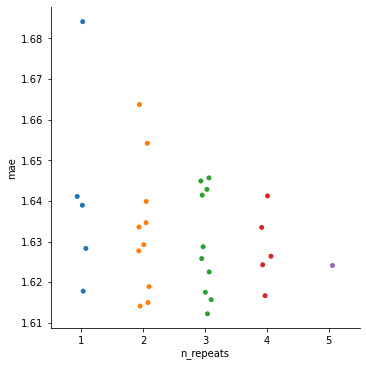

In [19]:
sns.catplot(x="n_repeats", y="mae", data=df_mae["no_transform"])

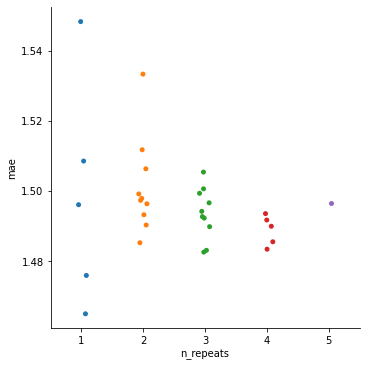

In [20]:
sns.catplot(x="n_repeats", y="mae", data=df_mae["target_log_transform"])

In [21]:
# results["bagging"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=False, n_estimators=20,
# )
# results["bagging_shuffle"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=True, n_estimators=10,
# )

In [22]:
results["bagging_target_transform"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False,
    ensembler="serial-bagging", shuffle=False, n_estimators=20,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
)
# results["bagging_shuffle_target_transform"] = get_cv_results(
#     n_splits=5, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=True, n_estimators=5,
#     target_transform_func=np.log, target_transform_inverse_func=np.exp,
# )

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

CV index [  0], Elapsed time:  0:42:43.228690


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CV index [  1], Elapsed time:  0:42:30.063830


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

CV index [  2], Elapsed time:  0:42:38.473642


/opt/tljh/user/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause t

CV index [  3], Elapsed time:  0:42:50.867677


distributed.core - INFO - Event loop was unresponsive in Nanny for 12.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 12.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

CV index [  4], Elapsed time:  0:43:30.473354


In [23]:
for key, res in results.items():
    test_accuracies = [cvr["test_mae"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_mae"] for cvr in res[0].values()]
    print(key, "mean", np.mean(test_accuracies))
    print(key, "std", np.std(test_accuracies))

no_transform mean 1.6383680268642338
no_transform std 0.11907503393107777
shuffle_no_transform mean 2.6245285778384733
shuffle_no_transform std 0.22152655149381115
target_log_transform mean 1.5057395788439016
target_log_transform std 0.11304435871313948
shuffle_target_log_transform mean 2.408932247816783
shuffle_target_log_transform std 0.17529290119389793
bagging_target_transform mean 1.5171607595653864
bagging_target_transform std 0.16486483177045966


In [24]:
with open("hbn_regression.pkl", "wb") as fp:
    pickle.dump(results, fp)

In [ ]:
bagging_results = results["bagging_target_transform"][0]